# Supplementary Information:
# Vapor-Liquid-Liquid Equilibria for the Water + Butanol + CPME Mixture

*G. Alonso, M. Cartes, A. Mejía*

We import the needed SGTpy modules to build a mixture and model it with SAFT-VR Mie EoS. Here we use the *component* function to load each pure component's SAFT parameters (*i.e.,* $m_{s,i}$, $\sigma_i$, $\varepsilon_i$, $\lambda_r$,$\lambda_a$, $n_{pol}$ and $\mu_{pol}$, the association parameters $\varepsilon_{ii}^{AB}$, $r_{c,ii}^{AB}$, $r_{dc,ii}^{AB}$ and the association scheme sites=[B,P,N]) 

Then each pure component is combined into a mixture by adding them together as c1 + c2 + c3 into the mix variable, where the binary interaction parameters can be loaded (*i.e.,* $k_{ij}$ matrix and $l_{ij}$ matrix) for associative pairs:

$\varepsilon_{ij}=\sqrt{\varepsilon_i \varepsilon_j}\frac{\sqrt[3]{\sigma_i^3 \sigma_j^3}}{\sigma_{ij}^3}(1-k_{ij})$

$\varepsilon_{ij}^{AB}=\sqrt{\varepsilon_{ii}^{AB} \varepsilon_{jj}^{AB}}(1-l_{ij})$

Finally, the mixture is loaded into the EoS with the *saftvrmie* function and the induced associative parameters are manually placed. For more information about how to set up a a mixture with SGTpy and calculate VLLE we refer the reader to the original GitHub documentation and examples page: 

https://github.com/gustavochm/sgtpy

https://github.com/gustavochm/sgtpy/blob/master/examples/

In [28]:
import numpy as np
from sgtpy import component, mixture, saftvrmie
from sgtpy.equilibrium import vlle
from scipy.optimize import minimize
import warnings
warnings.filterwarnings("ignore")

 
c1 = component('water',     Mw = 18.02,  ms = 1.731, sigma = 2.454, eps = 110.85, lambda_r =  8.308, lambda_a = 6.0, eAB = 1991.07, rcAB = 0.5624, rdAB = 0.4, sites = [0,2,2])
c2 = component('butanol2C', Mw = 74.12,  ms = 1.965, sigma = 4.108, eps = 277.89, lambda_r = 10.669, lambda_a = 6.0, eAB = 3300.00, rcAB = 0.2615, rdAB = 0.4, sites = [1,0,1], npol = 1.450, mupol = 1.661)
c3 = component('cpme',      Mw = 100.16, ms = 2.325, sigma = 4.136, eps = 343.91, lambda_r = 14.155, lambda_a = 6.0,                                           sites = [0,0,1], npol = 1.920, mupol = 1.270)

mix = c1 + c2 + c3
mix.kij_saft(np.array([[ 0,        -0.00736,    -0.01606 ],
                       [-0.00736,   0,           0.00130 ],
                       [-0.01606,   0.00130,     0 ]]))
mix.lij_saft(np.array([[0,         -0.00737,     0],
                       [-0.00737,   0,           0],
                       [0,          0,           0]]))

eos = saftvrmie(mix)
eos.eABij[2,0], eos.eABij[0,2] = c1.eAB/2, c1.eAB/2
eos.eABij[2,1], eos.eABij[1,2] = c2.eAB/2, c2.eAB/2
eos.rcij[2,0],  eos.rcij[0,2]  = 2.646 * 1e-10, 2.646 * 1e-10
eos.rcij[2,1],  eos.rcij[1,2]  = 1.774 * 1e-10, 1.774 * 1e-10         

# Phase equilibria initialization

We now calculate the VLLE of the two binary mixtures (*i.e.,* {Water(1) + Butanol(2)} and {Water(1) + CPME(3)}) that serve as initial and final points of the three-phase line with the *vlle* function.

The *vlle* function normally performs an isobaric-isothermic multiflash calculation using as initial guesses the composition of the aqueous ($x_0$), organic ($w_0$) and vapor ($y_0$) phases. However, since we are inputting binary compositions the function automatically identifies that only pressure needs to be fixed and finds the temperature and composition of the binary heteroazeotropes. The stability of the phases are automatically checked using the Gibbs tangent plane criterion and the function reports a "success" when it passes the check. 


In [29]:
P = 101325
# --------------------------------------------------
# Water (1) + Butanol (2) VLLE at P = 101325
# --------------------------------------------------
T = 360
x0 = np.array([0.99, 0.01, 0])
w0 = np.array([0.60, 0.40, 0])
y0 = np.array([0.80, 0.20, 0])
Z = y0

sol=vlle(x0, w0, y0, Z, T, P, eos, full_output=True)

T12 = sol.T
x12 = sol.X[0]
w12 = sol.X[1]
y12 = sol.X[2]
rhA12 = 1/(1000*sol.v[0]) * np.sum(x12*np.array([c1.Mw, c2.Mw, c3.Mw]))
rhO12 = 1/(1000*sol.v[1]) * np.sum(w12*np.array([c1.Mw, c2.Mw, c3.Mw]))
rhV12 = 1/(1000*sol.v[2]) * np.sum(y12*np.array([c1.Mw, c2.Mw, c3.Mw]))
r12 = sol.success
# --------------------------------------------------
# Water (1) + CPME (3) VLLE at P = 101325
# --------------------------------------------------
T = 360
x0 = np.array([0.99, 0, 0.01])
w0 = np.array([0.01, 0, 0.99])
y0 = np.array([0.60, 0, 0.40])
Z = y0

sol=vlle(x0, w0, y0, Z, T, P, eos, full_output=True)

T13 = sol.T
x13 = sol.X[0]
w13 = sol.X[1]
y13 = sol.X[2]
rhA13 = 1/(1000*sol.v[0]) * np.sum(x13*np.array([c1.Mw, c2.Mw, c3.Mw]))
rhO13 = 1/(1000*sol.v[1]) * np.sum(w13*np.array([c1.Mw, c2.Mw, c3.Mw]))
rhV13 = 1/(1000*sol.v[2]) * np.sum(y13*np.array([c1.Mw, c2.Mw, c3.Mw]))
r13 = sol.success

# --------------------------------------------------

print ("____________________________________________________________________________________________________")
print ("                                 T / K        x1     x2       w1     w2       y1     y2   success")
print ("____________________________________________________________________________________________________")
print (" Water(1) + Butanol(2) [VLLE] -> {:.2f}     {:.3f}  {:.3f}    {:.3f}  {:.3f}    {:.3f}  {:.3f}  {} ".format(T12, x12[0], x12[1], w12[0], w12[1], y12[0], y12[1], r12))
print (" Water(1) + CPME(3)    [VLLE] -> {:.2f}     {:.3f}  {:.3f}    {:.3f}  {:.3f}    {:.3f}  {:.3f}  {} ".format(sol.T,sol.X[0,0], sol.X[0,2],sol.X[1,0], sol.X[1,2],sol.X[2,0], sol.X[2,2], r13))
print ("____________________________________________________________________________________________________")


____________________________________________________________________________________________________
                                 T / K        x1     x2       w1     w2       y1     y2   success
____________________________________________________________________________________________________
 Water(1) + Butanol(2) [VLLE] -> 367.21     0.943  0.057    0.613  0.387    0.775  0.225  True 
 Water(1) + CPME(3)    [VLLE] -> 356.15     0.998  0.002    0.068  0.932    0.524  0.476  True 
____________________________________________________________________________________________________


### Calculate the three phase line

Then, we loop in temperature from the {Water(1) + Butanol(2)} binary to the {Water(1) + CPME(3)} binary updating the $T_i$ linearly from the 1+2 to the 1+3 mixture, so that:

$T_{i} = T_{12} + (T_{13}-T_{12})*\frac{i}{n_{points}}$      (this is done with the *np.linspace* function)

Then, we run an initial *vlle* function to converge the 1st ternary point with the previously explained isothermic-isobaric multiflash calculation. In ternary mixtures the phase stability is informed in the variable *tetha*, which reports a stable phase when the three *tetha* values from L1, L2 and V phases are equal to zero. If all three *tethas* are zero we consider the VLLE point converged and take its composition as initial guesses for the next point in the iteration.

If any *tetha* is different from zero we take its $x$, $y$ and $w$ values and try to reconverge it again by setting Z in the center of the $x$, $y$ and $w$ triangle. Once *theta* is equal zero we proceed to the next data point using the previously converged point.

#### Warning: Increase the float lenght in the print functions if data needs to be extracted from this Jupyter-Notebook to plot elsewhere. Here it has been reduced to show all data in a single line

In [31]:
def vlle_min(zi,args):
     # ------ This function looks for a Z that converges de VLLE -----#
    xi, wi, yi, Ti, Pi, eos = args   
    z3 = 1 - zi[0] - zi[1]      # This constraints z1+z2+z3 = 1
    if z3 <= 0:                 # And corrects the composition if z1+z2 > 1
        z3 = 1e-5               # keeping z1, fixing z3=1e-5 and making z2 to add 1
        zi[1] = 1-zi[0]-z3
    sol = vlle(xi, wi, yi, np.array([zi[0],zi[1],z3]), Ti, Pi, eos, full_output=True)
    #print ("{} {} {} | {:.2e} {:.2e} {:.2e} | {:.2e} {:.2e} {:.2e} {:.3e}".format(zi[0], zi[1], z3, sol.tetha[0],sol.tetha[1],sol.tetha[2], sol.beta[0], sol.beta[1], sol.beta[2], np.sum(sol.tetha**2) ))
    return np.sum(sol.tetha**2)  # We optimize for {FO = Σ θ^2 = 0}

def find_vlle3(x0, w0, y0, z, Ti, Pi, eos):
    # ------ This function calculates the ternary VLLE or it activates the VLLE search -----#
    sol = vlle(x0, w0, y0, z, Ti, Pi, eos, full_output=True)   # We first try to converge with the guess
    z = (sol.X[0]+sol.X[1]+sol.X[2])/3                         # When the guess does not work we get a new guess
    while np.any(sol.tetha != 0):                              # Based on previous VLLE and we try to reconverge it
        print ("-", end="")                                    # If it fails, then we minimize θ with the VLLE_MIN function
        sol = vlle(x0, w0, y0, z, Ti, Pi, eos, full_output=True)
        if np.any(sol.tetha != 0):
            args = np.array([x0, w0, y0, Ti, Pi, eos])
            bnds = ((1e-5, 0.99995), (1e-5, 0.99995))
            if z[0] == 0:         # If 2+3 binary, add 1 and minimize 
                print ("*", end="")
                sol = minimize(vlle_min, z[:2]+np.array([0.001,-0.001]), args=args, bounds=bnds)
            elif z[1] == 0:       # If 1+3 binary, add 2 and minimize 
                print ("*", end="")
                sol = minimize(vlle_min, z[:2]+np.array([-0.001,0.001]), args=args, bounds=bnds)
            elif z[0]+z[1] >= 1:  # If 1+2 binary, add 3 and minimize 
                print ("*", end="")
                sol = minimize(vlle_min, z[:2]+np.array([-0.001,0]), args=args, bounds=bnds)
            else:                 # If 1+2+3 binary, just minimize 
                print ("*", end="")
                sol = minimize(vlle_min, z[:2], args=args, bounds=bnds)

            # Try to converge with the newly found initial guess
            sol = vlle(x0, w0, y0, np.array([sol.x[0], sol.x[1], 1-sol.x[0]-sol.x[1]]), Ti, Pi, eos, full_output=True)
            #z = sol.x
            z = (sol.X[0]+sol.X[1]+sol.X[2])/3
    return sol

P = 101325
npoints = 101

T = np.linspace(T12, T13, npoints) 
x = np.zeros((npoints,3))
w = np.zeros((npoints,3))
y = np.zeros((npoints,3))
rhA = np.zeros(npoints)
rhO = np.zeros(npoints)
rhV = np.zeros(npoints)

x[0], x[-1] = x12, x13
w[0], w[-1] = w12, w13
y[0], y[-1] = y12, y13
rhA[0], rhA[-1] = rhA12, rhA13
rhO[0], rhO[-1] = rhO12, rhO13
rhV[0], rhV[-1] = rhV12, rhV13

# Start Looping from binary to binary
print ("     (K)                      (kg/m3)                   (kg/m3)                 (kg/m3)")
print ("      T       x1    x2    x3    ρ_A     w1    w2    w3    ρ_O    y1    y2    y3   ρ_V      θ :: β")
print ("_________________________________________________________________________________________________________________")
print ("{:<3d} {:.2f}   {:.3f} {:.3f} {:.3f} {:.1f}   {:.3f} {:.3f} {:.3f} {:.1f}  {:.2f} {:.3f} {:.3f} {:.1f}   BIN (1+2)".format(0, T[0], x[0,0], x[0,1], x[0,2], rhA[0], w[0,0], w[0,1], w[0,2], rhO[0], y[0,0], y[0,1], y[0,2],rhV[0],))
z = np.array([0.750, 0.245, 0.005])
for i in range(1, npoints-1):
    sol = find_vlle3(x[i-1], w[i-1], y[i-1], z , T[i], P, eos)

    x[i]= sol.X[0]
    w[i]= sol.X[1]
    y[i]= sol.X[2]
    z    = (x[i]+y[i]+w[i])/3

    rhA[i] = 1/(1000*sol.v[0]) * np.sum(x[i]*np.array([c1.Mw, c2.Mw, c3.Mw]))
    rhO[i] = 1/(1000*sol.v[1]) * np.sum(w[i]*np.array([c1.Mw, c2.Mw, c3.Mw]))
    rhV[i] = 1/(1000*sol.v[2]) * np.sum(y[i]*np.array([c1.Mw, c2.Mw, c3.Mw]))
    
    print ("{:<3d} {:.2f}   {:.3f} {:.3f} {:.3f} {:.1f}   {:.3f} {:.3f} {:.3f} {:.1f}  {:.3f} {:.3f} {:.3f} {:.1f}   {:.1f}|{:.1f}|{:.1f} :: {:.1f}|{:.1f}|{:.1f}".format(i, T[i], x[i,0], x[i,1], x[i,2], rhA[i], w[i,0], w[i,1], w[i,2], rhO[i], y[i,0], y[i,1], y[i,2], rhV[i], sol.tetha[0]*1e5,sol.tetha[1]*1e5,sol.tetha[2]*1e5, sol.beta[0], sol.beta[1], sol.beta[2]))

    
print ("{:<3d} {:.2f}   {:.3f} {:.3f} {:.3f} {:.1f}   {:.3f} {:.3f} {:.3f} {:.1f}  {:.3f} {:.3f} {:.3f} {:.1f}   BIN (1+3) ".format(npoints-1, T[-1], x[-1,0], x[-1,1], x[-1,2], rhA[-1], w[-1,0], w[-1,1], w[-1,2], rhO[-1], y[-1,0], y[-1,1], y[-1,2], rhV[-1]))
print ("_________________________________________________________________________________________________________________")
           

     (K)                      (kg/m3)                   (kg/m3)                 (kg/m3)
      T       x1    x2    x3    ρ_A     w1    w2    w3    ρ_O    y1    y2    y3   ρ_V      θ :: β
_________________________________________________________________________________________________________________
0   367.21   0.943 0.057 0.000 928.3   0.613 0.387 0.000 811.7  0.78 0.225 0.000 1.0   BIN (1+2)
-1   367.09   0.943 0.057 0.000 928.7   0.610 0.389 0.001 811.4  0.772 0.223 0.005 1.1   0.0|0.0|0.0 :: 0.3|0.3|0.4
7.787783729115307e-11 1.9413116114481316e-10
2   366.98   0.944 0.056 0.000 929.1   0.608 0.390 0.002 811.1  0.769 0.222 0.009 1.1   0.0|0.0|0.0 :: 0.5|0.5|0.1
6.840634945866018e-11 1.9098240933311448e-10
3   366.87   0.944 0.056 0.000 929.5   0.605 0.391 0.003 810.9  0.766 0.220 0.014 1.1   0.0|0.0|0.0 :: 0.4|0.4|0.2
9.425839988075627e-11 1.919311167922354e-10
4   366.76   0.944 0.055 0.000 929.9   0.603 0.393 0.004 810.6  0.763 0.218 0.018 1.1   0.0|0.0|0.0 :: 0.4|0.4|0.2
8.314422

50  361.68   0.963 0.035 0.002 948.0   0.451 0.431 0.117 800.9  0.636 0.147 0.217 1.5   0.0|0.0|0.0 :: 0.3|0.3|0.3
7.078332191698199e-11 1.8460216363588223e-10
51  361.57   0.964 0.034 0.002 948.5   0.447 0.431 0.122 800.7  0.634 0.145 0.221 1.5   0.0|0.0|0.0 :: 0.3|0.3|0.3
6.89806123048268e-11 1.8433546540359959e-10
52  361.46   0.964 0.034 0.002 948.9   0.442 0.431 0.127 800.6  0.631 0.144 0.225 1.5   0.0|0.0|0.0 :: 0.3|0.3|0.3
6.73684434474235e-11 1.8407160412218583e-10
53  361.35   0.965 0.033 0.002 949.3   0.438 0.430 0.133 800.4  0.629 0.142 0.229 1.6   0.0|0.0|0.0 :: 0.3|0.3|0.3
6.593515787039515e-11 1.8381017990233955e-10
54  361.24   0.965 0.033 0.002 949.7   0.433 0.429 0.138 800.3  0.626 0.141 0.233 1.6   0.0|0.0|0.0 :: 0.3|0.3|0.3
6.467102487659295e-11 1.835513589798042e-10
55  361.13   0.965 0.032 0.002 950.1   0.428 0.429 0.143 800.1  0.624 0.139 0.237 1.6   0.0|0.0|0.0 :: 0.3|0.3|0.3
6.356994751915529e-11 1.8329504958974215e-10
56  361.02   0.966 0.032 0.002 950.5   0.42

## VLLE plotting

Once the VLLE curve is found, we plot de non-isothermal VLLE phase diagram ($x,w,y$) in a ternary diagram using the *ternary* module coupled to *matplotlib*. Also the temperature projection ($T,x,w,y$) is included to complement the perspective.

Experimental data points are shown in black dots and their tie-lines are depicted in dotted lines. Blue, green and red curves correspond to the water, organic and vapor phase models, respectively. 

#### The 3D temperature plot view angle can be modified by changing the angles in  *ax2.view_init(20, -50)*


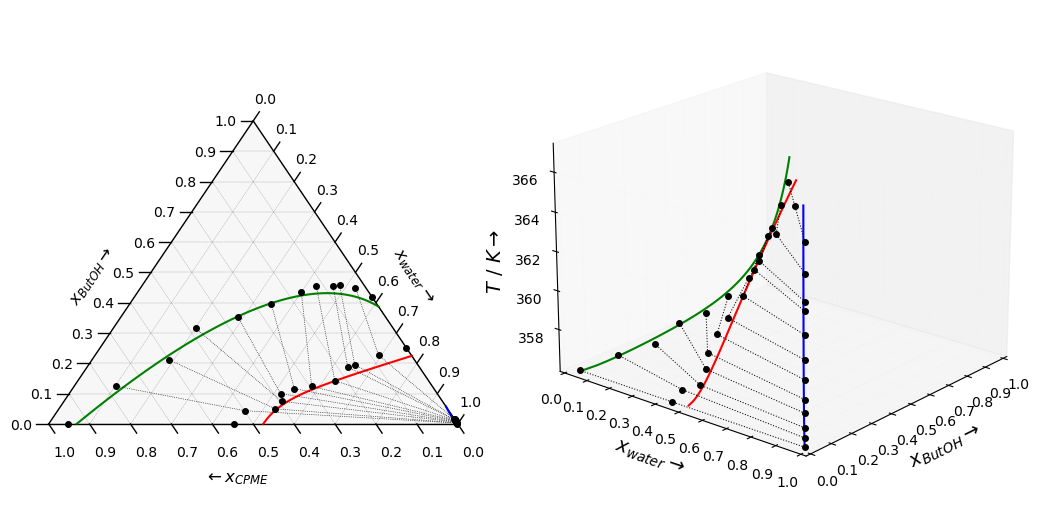

In [52]:
import matplotlib.pyplot as plt
import matplotlib.tri as mtri
import ternary
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D

# Experimental Data
Texp = np.array([365.77, 364.32, 362.99, 362.54, 361.41, 360.22, 359.27, 358.33, 357.67, 356.97, 356.48, 356.05])

Xexp = np.array([[0.983,  0.985,  0.987,  0.987,  0.988,  0.989,  0.991,  0.992,  0.993,  0.995,  0.996,  0.999],
                 [0.017,  0.015,  0.013,  0.013,  0.012,  0.011,  0.009,  0.007,  0.006,  0.004,  0.003,  0.000],
                 [0.000,  0.000,  2e-5,   3e-5,   3e-5,   4e-4,   8e-5,   0.001,  0.001,  0.001,  0.001,  0.001]])
Wexp = np.array([[0.580,  0.525,  0.483,  0.467,  0.426,  0.400,  0.347,  0.286,  0.201,  0.188,  0.102,  0.048],
                 [0.420,  0.450,  0.457,  0.456,  0.456,  0.435,  0.395,  0.353,  0.316,  0.212,  0.125,  0.000],
                 [0.000,  0.025,  0.06,   0.077,  0.118,  0.165,  0.258,  0.361,  0.483,  0.600,  0.773,  0.952]])
Yexp = np.array([[0.749,  0.693,  0.65,   0.637,  0.628,  0.581,  0.542,  0.517,  0.532,  0.529,  0.457,  0.453], 
                 [0.251,  0.227,  0.196,  0.188,  0.143,  0.124,  0.117,  0.100,  0.075,  0.050,  0.044,  0.000],
                 [0.000,  0.080,  0.154,  0.175,  0.229,  0.295,  0.341,  0.383,  0.393,  0.421,  0.499,  0.547]])

fig = plt.figure(figsize = (10,5), constrained_layout=True)
plt.rcParams['grid.linewidth'] = 0.01
# -------------------------------------------------------------------------------------------
# PLOT 1 non isothermal xyw triangular diagram
# -------------------------------------------------------------------------------------------
ax1 = fig.add_subplot(121)
tax = ternary.TernaryAxesSubplot(ax=ax1, scale = 1)
tax.boundary(linewidth=1.0)
tax.gridlines(color="black", multiple=0.1, linewidth=0.2)
# Set ticks
tax.ticks(clockwise=True, multiple=0.1, linewidth=1, offset = 0.03, tick_formats='%.1f')
#Set component labels
tax.right_axis_label(r"$x_{water}\rightarrow$", fontsize=12, offset = 0.15)
tax.left_axis_label(r"$x_{ButOH} \rightarrow$", fontsize=12, offset = 0.15)
tax.bottom_axis_label(r"$\leftarrow x_{CPME}$", fontsize=12, offset = 0.15)
# Remove default Matplotlib Axes
tax.clear_matplotlib_ticks()
tax._redraw_labels()
ax1.set_axis_off()
# -------------------------------------------------------------------------------------------
# plot the VLLE results obtanined by SAFT-VR Mie in the previous code-block
tax.plot(x, color = 'b')
tax.plot(w, color = 'g')
tax.plot(y, color = 'r')  
# -------------------------------------------------------------------------------------------
# Plot the experimental Tie-Lines
for i in range(0,len(Texp)):
    tax.plot([Xexp.transpose()[i], Yexp.transpose()[i], Wexp.transpose()[i]], marker='o', markersize=4, linestyle='dotted', color='k', linewidth=0.5)
# -------------------------------------------------------------------------------------------
# PLOT 2 Txyw 3D diagram
# -------------------------------------------------------------------------------------------
ax2 = fig.add_subplot(122, projection='3d')
ax2.view_init(20, -50)      # This can be touched
ax2.axes.set_xlim3d(left=0, right=1) 
ax2.axes.set_ylim3d(bottom=0, top=1) 
ax2.set_xticks(np.arange(0,1.1,0.1), minor=False)
ax2.set_yticks(np.arange(0,1.1,0.1), minor=False)
ax2.set_xlabel(r"$x_{water}\rightarrow$", fontsize=14)
ax2.set_ylabel(r"$x_{ButOH}\rightarrow$", fontsize=14)
ax2.set_zlabel(r"$T\ /\ K\rightarrow$", fontsize=14, rotation=90)
ax2.zaxis.set_rotate_label(False)  # disable automatic rotation
tmp_planes = ax2.zaxis._PLANES 
ax2.zaxis._PLANES = ( tmp_planes[2], tmp_planes[3], 
                     tmp_planes[0], tmp_planes[1], 
                     tmp_planes[4], tmp_planes[5])

# -------------------------------------------------------------------------------------------
# plot the VLLE results obtanined by SAFT-VR Mie in the previous code-block
ax2.plot(x[:,0], x[:,1], T, label='Tri_AC',color='b', linewidth=1.5 )
ax2.plot(w[:,0], w[:,1], T, label='Tri_Org',color='g', linewidth=1.5)
ax2.plot(y[:,0], y[:,1], T, label='Tri_Vap',color='r', linewidth=1.5)
# -------------------------------------------------------------------------------------------
# Plot the experimental Tie-Lines
for i in range(len(Texp)):
    ax2.plot([Xexp[0,i], Yexp[0,i], Wexp[0,i]], [Xexp[1,i], Yexp[1,i], Wexp[1,i]], [Texp[i], Texp[i], Texp[i]],
            label='exp', color='k', marker='o', markersize=4, linestyle='dotted', linewidth=0.75)
# -------------------------------------------------------------------------------------------
ax1.set_position([0, 0.1, 0.45, 0.7])  # Make it smaller and shifted to the left
ax2.set_position([0.4, 0, 0.7, 1])     # Make it bigger and shifted to the right

